In [1]:
import utils
from get_dataset import get_dataset
import random
import time
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import Iterator
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [3]:
# Setup logger
import logging
import sys
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %H:%M:%S')  

In [4]:
dataset, emb_weights = get_dataset()
dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

05/06/2020 18:48:08 INFO : Downloading data
05/06/2020 18:48:09 INFO : Downloading GloVe word vectors
05/06/2020 18:48:09 INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
05/06/2020 18:48:14 INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


<br>

In [37]:
class Baseline_model(nn.Module):
  """
  """
  def __init__(self, vocab_size, embed_dim, embed_vecs=None):
    super().__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    if embed_vecs is not None:
      self.embedding = nn.EmbeddingBag.from_pretrained(embed_vecs)
    else:
      self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
    self.head = nn.Sequential(nn.Linear(embed_dim, embed_dim//2),
                              nn.ReLU(),
                              nn.Linear(embed_dim//2, 2))

  def forward(self, batch):
    batch, lengths = batch
    
    batch_concat = torch.cat([review[:length] for review, length in zip(batch, lengths)], dim=0)
    offsets = torch.cat([torch.tensor([0]), torch.cumsum(lengths[:-1], dim=0)])
    
    out = self.embedding(batch_concat, offsets)
    return self.head(out)

In [38]:
def learner(model, loss_fn, optimiser, epochs=1, bs=1, device=device):
  start_time = time.time()
  for epoch in range(epochs):
    
    total_loss = 0
    for i, batch in enumerate(Iterator(ds_train, bs, shuffle=True, device=device), 1):
      optimiser.zero_grad()

      output = model(batch.review)
      loss = loss_fn(output, batch.label)
      total_loss += loss.item()

      loss.backward()
      optimiser.step()

      if not i % (len(ds_train)//(bs*3)):
        avg_loss = total_loss / (len(ds_train)//(bs*3))
        val_loss, val_accuracy = utils.validate(ds_val, loss_fn, model, bs)
        print('Epoch : {}, batch : {}, train_loss = {:.4f}, val_loss = {:.4f}, val_accuracy : {:.3f}, time = {:.0f}s'.format(
            epoch + 1, i, avg_loss, val_loss, val_accuracy, time.time() - start_time))
        total_loss = 0

<br>

In [50]:
vocab_size = len(emb_weights)
embed_size = 300

model = Baseline_model(vocab_size, embed_size, emb_weights.clone()).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

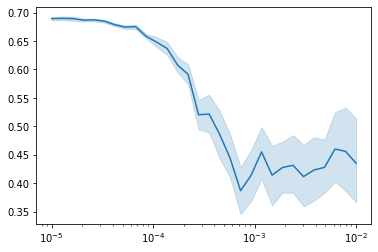

In [40]:
optimiser = Adam(model.parameters())
utils.lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=50)

In [51]:
optimiser = Adam(model.parameters(), lr=2e-4)
learner(model, loss_fn, optimiser, epochs=10, bs=8)

Epoch : 1, batch : 100, train_loss = 0.6750, val_loss = 0.6627, val_accuracy : 0.587, time = 0s
Epoch : 1, batch : 200, train_loss = 0.6269, val_loss = 0.6070, val_accuracy : 0.743, time = 0s
Epoch : 1, batch : 300, train_loss = 0.5759, val_loss = 0.5683, val_accuracy : 0.710, time = 1s
Epoch : 2, batch : 100, train_loss = 0.5330, val_loss = 0.5358, val_accuracy : 0.733, time = 1s
Epoch : 2, batch : 200, train_loss = 0.4819, val_loss = 0.4897, val_accuracy : 0.787, time = 1s
Epoch : 2, batch : 300, train_loss = 0.4695, val_loss = 0.4867, val_accuracy : 0.750, time = 1s
Epoch : 3, batch : 100, train_loss = 0.4491, val_loss = 0.4758, val_accuracy : 0.777, time = 2s
Epoch : 3, batch : 200, train_loss = 0.4123, val_loss = 0.4475, val_accuracy : 0.800, time = 2s
Epoch : 3, batch : 300, train_loss = 0.4278, val_loss = 0.4527, val_accuracy : 0.787, time = 2s
Epoch : 4, batch : 100, train_loss = 0.4099, val_loss = 0.4532, val_accuracy : 0.780, time = 3s
Epoch : 4, batch : 200, train_loss = 0.3

In [52]:
optimiser = Adam(model.parameters(), lr=1e-4)
learner(model, loss_fn, optimiser, epochs=5, bs=8)

Epoch : 1, batch : 100, train_loss = 0.3411, val_loss = 0.4230, val_accuracy : 0.810, time = 0s
Epoch : 1, batch : 200, train_loss = 0.3136, val_loss = 0.4149, val_accuracy : 0.817, time = 1s
Epoch : 1, batch : 300, train_loss = 0.3497, val_loss = 0.4134, val_accuracy : 0.813, time = 1s
Epoch : 2, batch : 100, train_loss = 0.3375, val_loss = 0.4237, val_accuracy : 0.810, time = 1s
Epoch : 2, batch : 200, train_loss = 0.3107, val_loss = 0.4154, val_accuracy : 0.817, time = 1s
Epoch : 2, batch : 300, train_loss = 0.3483, val_loss = 0.4135, val_accuracy : 0.817, time = 2s
Epoch : 3, batch : 100, train_loss = 0.3347, val_loss = 0.4241, val_accuracy : 0.817, time = 2s
Epoch : 3, batch : 200, train_loss = 0.3081, val_loss = 0.4156, val_accuracy : 0.817, time = 2s
Epoch : 3, batch : 300, train_loss = 0.3466, val_loss = 0.4136, val_accuracy : 0.817, time = 2s
Epoch : 4, batch : 100, train_loss = 0.3324, val_loss = 0.4245, val_accuracy : 0.817, time = 3s
Epoch : 4, batch : 200, train_loss = 0.3

In [ ]:
# if not os.path.exists('models'):
#     os.makedirs('models')
# torch.save(model.state_dict(), 'models/model_baseline.pt')

In [53]:
model.embedding.weight.requires_grad_(True);
optimiser = Adam(model.parameters(), lr=1e-4)
learner(model, loss_fn, optimiser, epochs=10, bs=8)

Epoch : 1, batch : 100, train_loss = 0.3284, val_loss = 0.4219, val_accuracy : 0.817, time = 1s
Epoch : 1, batch : 200, train_loss = 0.2971, val_loss = 0.4087, val_accuracy : 0.823, time = 3s
Epoch : 1, batch : 300, train_loss = 0.3373, val_loss = 0.4021, val_accuracy : 0.820, time = 4s
Epoch : 2, batch : 100, train_loss = 0.3076, val_loss = 0.4088, val_accuracy : 0.820, time = 6s
Epoch : 2, batch : 200, train_loss = 0.2718, val_loss = 0.3973, val_accuracy : 0.823, time = 7s
Epoch : 2, batch : 300, train_loss = 0.3109, val_loss = 0.3915, val_accuracy : 0.830, time = 8s
Epoch : 3, batch : 100, train_loss = 0.2852, val_loss = 0.3978, val_accuracy : 0.827, time = 10s
Epoch : 3, batch : 200, train_loss = 0.2479, val_loss = 0.3883, val_accuracy : 0.843, time = 12s
Epoch : 3, batch : 300, train_loss = 0.2866, val_loss = 0.3825, val_accuracy : 0.843, time = 13s
Epoch : 4, batch : 100, train_loss = 0.2636, val_loss = 0.3886, val_accuracy : 0.827, time = 15s
Epoch : 4, batch : 200, train_loss =

In [54]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*utils.validate(ds_test, loss_fn, model)))

Test loss : 0.30312, test accuracy : 0.857


In [10]:
# torch.save(model.state_dict(), 'models/model_baseline_fine.pt')